# 02 - Semi-Supervised Approach for Image Classification

In this notebook, we apply a semi-supervised strategy to improve image classification. We propagate known labels, generate pseudo-labels for unlabeled data, and evaluate a supervised classifier trained on the enriched dataset.


In [1]:
import sys
from pathlib import Path
# Ajouter src/ au PYTHONPATH
sys.path.append(str(Path("..") / "src"))

P_EMB = "/workspace/models"

## A - Load embeddings and labels

We load the feature embeddings extracted in the previous notebook, along with their labels. These are used to propagate labels and generate pseudo-labels.


In [2]:
from src.label_propagation import load_embeddings

X, y = load_embeddings(P_EMB)
print("Feature shape :", X.shape)
print("Shape des labels :", y.shape)

Shape des features : (100, 512)
Shape des labels : (100,)


> X is a table with 100 rows and 512 columns, where each row is a numeric summary of the original image learned by the CNN.
>
> y is a table with 100 rows and one column (one label per image).


## B - Simulate a partially labeled scenario

We simulate real-world constraints by masking most labels at random (e.g., 90% unlabeled).


In [3]:
from src.label_propagation import mask_labels

UNLABELED_RATIO = 0.9
y_masked, _ = mask_labels(y, unlabeled_ratio=UNLABELED_RATIO, seed=42)

import numpy as np
print("Labels initiaux :", np.unique(y, return_counts=True))
print("Labels after masking :", np.unique(y_masked, return_counts=True))

Labels initiaux : (array([0, 1]), array([50, 50]))
Labels after masking : (array([-1,  0,  1]), array([95,  4,  1]))


> We now have a partially labeled dataset where only 5 out of 100 examples keep their label (4 from class 0, 1 from class 1).


## C - Propagate known labels

We apply Label Propagation to infer labels for unlabeled data using embedding similarity.

We test multiple kernels (rbf, knn) and observe how hyperparameters (gamma, n_neighbors) affect outcomes.


In [4]:
from src.label_propagation import run_label_propagation

# kernel can be "knn" or "rbf"
y_propagated, model = run_label_propagation(
    X, y_masked,
    kernel="rbf",
    n_neighbors=10,
    gamma=20
)

print("Labels after propagation :", np.unique(y_propagated, return_counts=True))

Labels after propagation : (array([0, 1]), array([98,  2]))


> After label propagation, the class distribution is heavily imbalanced: 98 in class 0 vs 2 in class 1.
>
> This is common in low-label regimes where class separation is weak. The goal of this notebook is to improve predictions via pseudo-labelling and supervised re-training.


## D - Generate pseudo-labels with a supervised classifier

We train a classifier (Logistic Regression with `class_weight='balanced'`) on the labeled subset, then pseudo-label unlabeled samples above a confidence threshold.

This process can be iterated to expand the labeled set progressively.


In [5]:
from src.pseudo_labelling import run_pseudo_labelling

y_pseudo = run_pseudo_labelling(
    X, y_masked,
    confidence_threshold=0.95,
    max_iters=5,
    class_weight="balanced"
)

print("Labels after pseudo-labeling :", np.unique(y_pseudo, return_counts=True))

Labels after pseudo-labeling : (array([-1,  0,  1]), array([36, 37, 27]))


> The pseudo-labelling step assigned labels to 73 images (36 + 37), while 27 were ignored due to low confidence (< 0.95).
>
> The resulting class balance (roughly 50/50) is much better than label propagation (98/2).
>
> This shows that supervised pseudo-labelling can learn better decision boundaries and produce more reliable labels.


## E - Final evaluation

We train a classifier on the enriched dataset (true + pseudo labels) and evaluate on the test set.

Evaluation includes:
- Confusion matrix
- Classification report
- ROC AUC curves
- Threshold tuning


Classification report :

              precision    recall  f1-score   support

          -1       0.86      0.86      0.86         7
           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.90        20
   macro avg       0.92      0.89      0.90        20
weighted avg       0.91      0.90      0.90        20



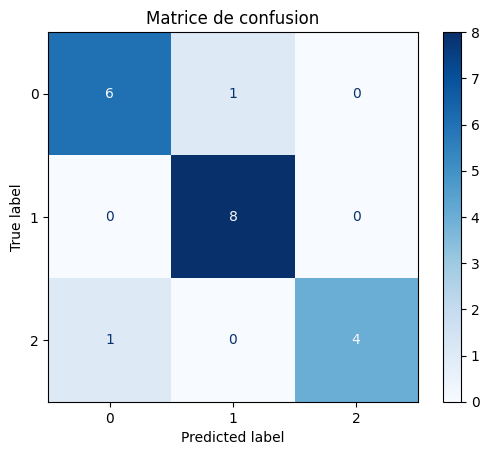

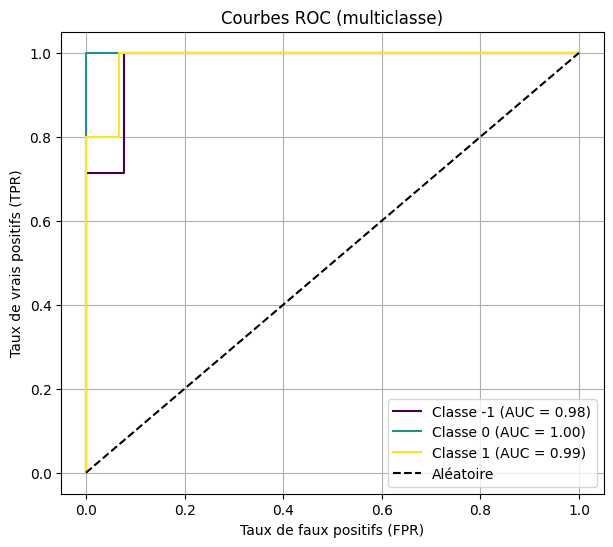

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Train the model on pseudo-labels
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y_pseudo,
    test_size=0.2,
    random_state=42,
    stratify=y_pseudo
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Affichage du rapport de classification
print("Classification report :\n")
print(classification_report(y_test, y_pred))

# Affichage de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matrice de confusion")
plt.show()

# Gestion automatique du cas binaire vs multiclass
unique_classes = np.unique(y_test)

if len(unique_classes) == 2:
    # Cas binaire : courbe ROC classique
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("Taux de faux positifs (FPR)")
    plt.ylabel("Taux de vrais positifs (TPR)")
    plt.title("Courbe ROC")
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    # Cas multiclasse : One-vs-Rest
    y_test_bin = label_binarize(y_test, classes=unique_classes)
    y_prob_all = pipeline.predict_proba(X_test)
    n_classes = y_test_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_all[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Affichage
    plt.figure(figsize=(7, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, label=f"Classe {unique_classes[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("Taux de faux positifs (FPR)")
    plt.ylabel("Taux de vrais positifs (TPR)")
    plt.title("Courbes ROC (multiclasse)")
    plt.legend()
    plt.grid(True)
    plt.show()

## Conclusion

We implemented a semi-supervised approach to improve classification performance on a partially labeled medical dataset. Two strategies were explored:

- **Label propagation** to infer labels from a small labeled subset.
- **Pseudo-labelling** to generate high-confidence labels using a supervised classifier.

### Results

- Final model reached a **macro F1-score around 0.90**, far above the near-zero ARI of unsupervised clustering.
- Confusion matrix shows strong class separation, with minor confusion between `-1` and `1`.
- ROC curves show high discriminative power (AUC > 0.98).

These results confirm the value of semi-supervised learning when labeled data is scarce.
